## Tasks

- make a fluid/defaults splits as needed for each modification
- Try different ways to reduce overfitting and divergence
    - add dropout to each gru layer?
    - learning rate?
    - L2 ...
- implement dlnd_character_example model in kur (make sure the model structure first)
- How can I change directories inside `fluid.yml` rather than in `defaults.yml`?
- it says people spend 30-40% time on gathering, cleaning and feature engineering dataset. Kur is taking care of them by defaults. Then the tasks to complete is to add more feature engineering features, right?



In [1]:
# make sure you are at a level of directory with all the py files
%pwd

'/Users/Natsume/Downloads/kur_road/character_rnn'

In [3]:
%ls

__pycache__/        cleaned.txt         t1/                 vocab.py
books/              data/               view_data.py
char_rnn_demo.yaml  make_data.py        view_logs.py
char_rnn_kur.ipynb  steps.sh            view_outputs.py


## **Create a small dataset for speed**

- inside `make_data.py` set `dev=True` to reduce data size by x10
- make_data create a data file named cleaned.txt
- It is nice we can control size of dataset, so I wonder is it possible to **use `provider` inside kurfile.yaml to control how much data to use**? 

**Effect of doing the above**
- make_data.py only takes a few seconds
- `kur -v train kurfile.yaml` only takes less than 4 mins, compared to default setting's estimated 5 hours training 
- Also the previous 30 minutes loading time is gone too
- **What made it to take 30 mins to load previously**? was it the large dataset? with smaller dataset, loading time reduced?

In [1]:
%%time
!python make_data.py

0 13300
dims:
(13300, 30, 30)
(13300, 30)
13300 14131
dims:
(831, 30, 30)
(831, 30)
14131 14962
dims:
(831, 30, 30)
(831, 30)
14962 15793
dims:
(831, 30, 30)
(831, 30)
CPU times: user 260 ms, sys: 307 ms, total: 567 ms
Wall time: 15.1 s


## Let's view the data

In [2]:
%%time
!python view_data.py
# below is last bit of data from trainingset, validation set, test set, evaluation set
# left part of --> is X or input
# right part of --> is y or output

## If needed, I shall dig into it to see more of the data



peek at train:
------
"the project gutenberg ebook of" --> " "
"he project gutenberg ebook of " --> "p"
"e project gutenberg ebook of p" --> "r"
------
"o particular resentment by his" --> " "
" particular resentment by his " --> "h"
"particular resentment by his h" --> "a"


peek at validate:
------
"articular resentment by his ha" --> "v"
"rticular resentment by his hav" --> "i"
"ticular resentment by his havi" --> "n"
------
"ingley for a kingdom upon my h" --> "o"
"ngley for a kingdom upon my ho" --> "n"
"gley for a kingdom upon my hon" --> "o"


peek at test:
------
"ley for a kingdom upon my hono" --> "u"
"ey for a kingdom upon my honou" --> "r"
"y for a kingdom upon my honour" --> " "
------
"sting your time with me. mr. b" --> "i"
"ting your time with me. mr. bi" --> "n"
"ing your time with me. mr. bin" --> "g"


peek at evaluate:
------
"ng your time with me. mr. bing" --> "l"
"g your time with me. mr. bingl" --> "e"
" your time with me. mr. bingle" --> "y"
------
"they had 

## Let's see the original kurfile

In [6]:
%pycat char_rnn_demo.yaml
# copy and paste kurfile.yaml before to see the kurfile

In [1]:
%%writefile char_rnn_demo.yaml

---

settings:

  vocab:
    size: 30

  rnn:
    size: 128
    depth: 3

model:
  - input: in_seq

  - for:
      range: "{{ rnn.depth - 1 }}"
      iterate:
        - recurrent:
            size: "{{ rnn.size }}"
            type: gru
            sequence: yes
            bidirectional: no
        - batch_normalization

  - recurrent:
      size: "{{ rnn.size }}"
      type: gru
      sequence: no
      bidirectional: no

  - dense: "{{ vocab.size }}"

  - activation: softmax

  - output: out_char

loss:
  - target: out_char
    name: categorical_crossentropy

train:
  data:
    - jsonl: data/train.jsonl
  epochs: 5                                
  weights:
    initial: t1/best.w.kur
    best: t1/best.w.kur
    last: t1/last.w.kur
  log: t1/log
  hooks:                                   # Let plot loss
    - plot: t1/loss.png


validate:
  data:
    - jsonl: data/validate.jsonl
  weights: t1/best.w.kur


test:
  data:
    - jsonl: data/test.jsonl
  weights: t1/best.w.kur


evaluate:
  data:
    - jsonl: data/evaluate.jsonl
  weights: t1/best.w.kur

  destination: t1/output.pkl

Overwriting char_rnn_demo.yaml


## Train the original model
- data is created and stored inside data/ in the same level of model/
- from the loss plot below, we see **overfitting and divergence**, what is the cause and how to reduce overfit and make better convergence? 
    - add drop out
    - use LSTM instead of GRU?
    

In [3]:
%ls

__pycache__/                      data/
books/                            data_supplier_char_rnn/
char_rnn_demo.yaml                make_data.py
char_rnn_demo_defaults.yaml       steps.sh
char_rnn_demo_dlnd_defaults.yaml  t1/
char_rnn_demo_dp_defaults.yaml    t2_dp/
char_rnn_kur.ipynb                t3_dlnd/
char_rrn_demo_dlnd_fluid.yaml     view_data.py
char_rrn_demo_dp_fluid.yaml       view_logs.py
char_rrn_demo_fluid.yaml          view_outputs.py
cleaned.txt                       vocab.py


In [4]:
%%time
!kur -v train char_rnn_demo.yaml

[INFO 2017-03-05 21:25:22,495 kur.kurfile:699] Parsing source: char_rnn_demo.yaml, included by top-level.
[INFO 2017-03-05 21:25:22,506 kur.kurfile:82] Parsing Kurfile...
[INFO 2017-03-05 21:25:22,525 kur.loggers.binary_logger:71] Loading log data: t1/log
[INFO 2017-03-05 21:25:26,980 kur.backend.backend:80] Creating backend: keras
[INFO 2017-03-05 21:25:26,980 kur.backend.backend:83] Backend variants: none
[INFO 2017-03-05 21:25:26,980 kur.backend.keras_backend:122] No particular backend for Keras has been requested.
[INFO 2017-03-05 21:25:28,086 kur.backend.keras_backend:195] Keras is loaded. The backend is: theano
[INFO 2017-03-05 21:25:28,086 kur.model.model:260] Enumerating the model containers.
[INFO 2017-03-05 21:25:28,086 kur.model.model:265] Assembling the model dependency graph.
[INFO 2017-03-05 21:25:28,086 kur.model.model:280] Connecting the model graph.
[INFO 2017-03-05 21:25:29,110 kur.model.model:284] Model inputs:  in_seq
[INFO 2017-03-05 21:25:29,111 kur.model.model:28

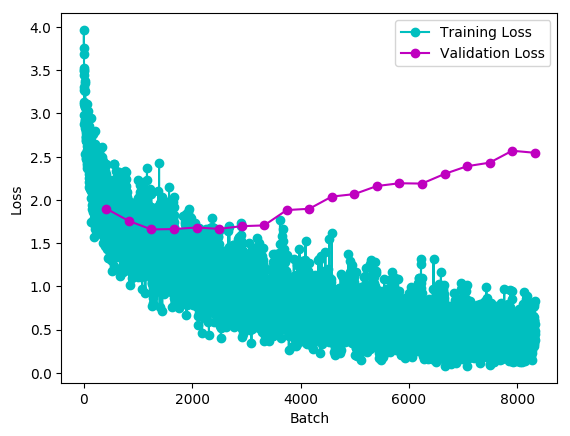

In [5]:
from IPython.display import Image
Image(filename='t1/loss.png')

## split original kurfile into 2 kurfiles for easy modify
- give `epochs:` a default value and an overide value

In [9]:
%%writefile char_rnn_demo_defaults.yaml

---

settings:

  vocab:
    size: 30

  rnn:
    size: 128
    depth: 3

model:
  - input: in_seq

  - for:
      range: "{{ rnn.depth - 1 }}"
      iterate:
        - recurrent:
            size: "{{ rnn.size }}"
            type: gru
            sequence: yes
            bidirectional: no
        - batch_normalization

  - recurrent:
      size: "{{ rnn.size }}"
      type: gru
      sequence: no
      bidirectional: no

  - dense: "{{ vocab.size }}"

  - activation: softmax
#       name: out_char                      # won't work!
  - output: out_char                        # QUESTION: in mnist and cifar example, we have `name: labels` but 
                                            # no `- output: labels`, why we use `- output: out_char` not just use
                                            # `name: out_char`

loss:
  - target: out_char
    name: categorical_crossentropy

train:
  data:
    - jsonl: data/train.jsonl
  epochs: "{{ num_epochs|default(5) }}"     # add default and overide values
  weights:
    initial: t1/best.w.kur
    best: t1/best.w.kur
    last: t1/last.w.kur
  log: t1/log
  hooks:                                   # Let plot loss
#     - plot: t1/loss.png
    - plot:
        loss_per_batch: t1/loss1.png
        loss_per_time: t1/loss2.png
        throughput_per_time: t1/loss3.png

validate:
  data:
    - jsonl: data/validate.jsonl
  weights: t1/best.w.kur


test:
  data:
    - jsonl: data/test.jsonl
  weights: t1/best.w.kur


evaluate:
  data:
    - jsonl: data/evaluate.jsonl
  weights: t1/best.w.kur

  destination: t1/output.pkl

Overwriting char_rnn_demo_defaults.yaml


In [10]:
%%writefile char_rrn_demo_fluid.yaml

---
settings: 
  num_epochs: 1


include: char_rnn_demo_defaults.yaml
...

Overwriting char_rrn_demo_fluid.yaml


In [11]:
%%time
!kur -v train char_rrn_demo_fluid.yaml

[INFO 2017-03-05 21:50:35,663 kur.kurfile:699] Parsing source: char_rrn_demo_fluid.yaml, included by top-level.
[INFO 2017-03-05 21:50:35,667 kur.kurfile:699] Parsing source: char_rnn_demo_defaults.yaml, included by char_rrn_demo_fluid.yaml.
[INFO 2017-03-05 21:50:35,679 kur.kurfile:82] Parsing Kurfile...
[INFO 2017-03-05 21:50:35,703 kur.loggers.binary_logger:71] Loading log data: t1/log
[INFO 2017-03-05 21:50:39,277 kur.backend.backend:80] Creating backend: keras
[INFO 2017-03-05 21:50:39,277 kur.backend.backend:83] Backend variants: none
[INFO 2017-03-05 21:50:39,278 kur.backend.keras_backend:122] No particular backend for Keras has been requested.
[INFO 2017-03-05 21:50:40,328 kur.backend.keras_backend:195] Keras is loaded. The backend is: theano
[INFO 2017-03-05 21:50:40,329 kur.model.model:260] Enumerating the model containers.
[INFO 2017-03-05 21:50:40,329 kur.model.model:265] Assembling the model dependency graph.
[INFO 2017-03-05 21:50:40,329 kur.model.model:280] Connecting th

**In average, it takes 6 minutes to run 5 epochs, compared with first 5 epochs 5:40 min**

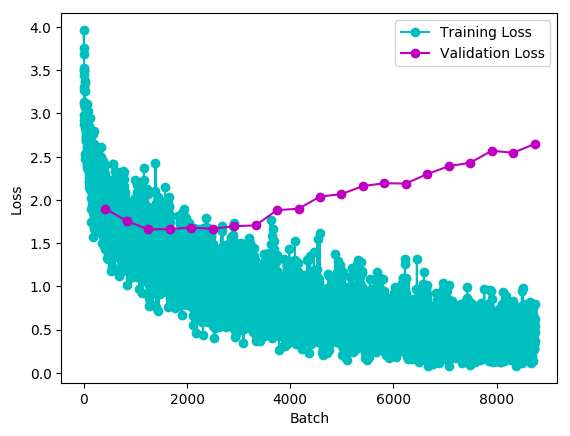

In [6]:
from IPython.display import Image
Image(filename='t1/loss1.png') # overfitting and divergence !!!!!!!!!!!!!

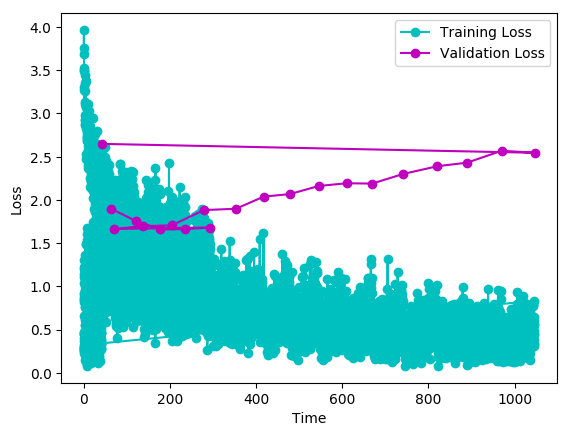

In [7]:
Image(filename='t1/loss2.png') # overfitting and divergence !!!!!!!!!!!!!

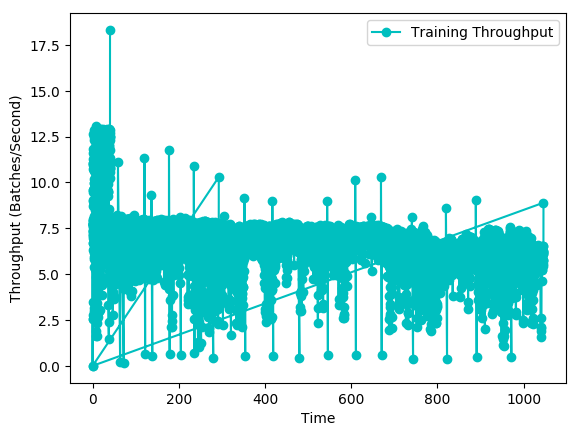

In [8]:
Image(filename='t1/loss3.png') # overfitting and divergence !!!!!!!!!!!!!

## Evaluate and display output and accuracy
**QUESTION**
- what exactly is the purpose of evaluate?
- what is the output?
- is slightly **over 50% accuracy** is considered good result? How so?

In [12]:
%%time
!kur -v evaluate char_rnn_demo.yaml

[INFO 2017-03-05 21:56:19,006 kur.kurfile:699] Parsing source: char_rnn_demo.yaml, included by top-level.
[INFO 2017-03-05 21:56:19,017 kur.kurfile:82] Parsing Kurfile...
[INFO 2017-03-05 21:56:19,254 kur.backend.backend:80] Creating backend: keras
[INFO 2017-03-05 21:56:19,255 kur.backend.backend:83] Backend variants: none
[INFO 2017-03-05 21:56:19,255 kur.backend.keras_backend:122] No particular backend for Keras has been requested.
[INFO 2017-03-05 21:56:20,281 kur.backend.keras_backend:195] Keras is loaded. The backend is: theano
[INFO 2017-03-05 21:56:20,282 kur.model.model:260] Enumerating the model containers.
[INFO 2017-03-05 21:56:20,282 kur.model.model:265] Assembling the model dependency graph.
[INFO 2017-03-05 21:56:20,282 kur.model.model:280] Connecting the model graph.
[INFO 2017-03-05 21:56:21,171 kur.model.model:284] Model inputs:  in_seq
[INFO 2017-03-05 21:56:21,171 kur.model.model:285] Model outputs: out_char
[INFO 2017-03-05 21:56:24,031 kur.backend.keras_backend:66

In [13]:
%pycat view_outputs.py

# we must get output.pkl into and from the correct directory

In [24]:
%%writefile view_outputs.py

"""
Copyright 2016 Deepgram

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

import numpy as np
import pickle
import sys
import view_data
from vocab import *


if len(sys.argv) < 2:
    pickle_fname = 't1/output.pkl'
else:
    pickle_fname = sys.argv[1]

with open(pickle_fname, 'rb') as infile:
    prediction_data = pickle.load(infile)

data = view_data.get_data('evaluate')

batch_size = len(prediction_data['truth']['out_char'])

for j in range(10):
    predicted_char = int_to_char[np.argmax(prediction_data['result']['out_char'][j])]
    correct_char = int_to_char[np.argmax(data['out_char'][j])]
    print(
        '"%s" --> "%s"' % (
            ''.join([
                int_to_char[np.argmax(_)]
                for _ in data['in_seq'][j]
            ]),
            predicted_char
        )
    )
    if predicted_char == correct_char:
        print((' ' * (seq_len + 5)) + 'CORRECT')
    else:
        print((' ' * (seq_len + 5)) + 'INCORRECT (%s)' % correct_char)

accuracy = sum(
    [
        int(
            np.argmax(prediction_data['result']['out_char'][i]) == np.argmax(prediction_data['truth']['out_char'][i])
        )
        for i in range(batch_size)
    ]
) / float(len(prediction_data['truth']['out_char']))

print('accuracy = %s' % accuracy)

Overwriting view_outputs.py


In [14]:
!python view_outputs.py

"ng your time with me. mr. bing" --> "l"
                                   CORRECT
"g your time with me. mr. bingl" --> "e"
                                   CORRECT
" your time with me. mr. bingle" --> "y"
                                   CORRECT
"your time with me. mr. bingley" --> " "
                                   CORRECT
"our time with me. mr. bingley " --> "w"
                                   INCORRECT (f)
"ur time with me. mr. bingley f" --> "o"
                                   CORRECT
"r time with me. mr. bingley fo" --> "r"
                                   INCORRECT (l)
" time with me. mr. bingley fol" --> "l"
                                   CORRECT
"time with me. mr. bingley foll" --> "o"
                                   CORRECT
"ime with me. mr. bingley follo" --> "w"
                                   CORRECT
accuracy = 0.5054151624548736


## Test 
- it only provides us with test loss
- QUESTION: why test don't save, print output and accuracy?

In [15]:
%%time
!kur -v test char_rnn_demo.yaml

[INFO 2017-03-05 21:56:58,008 kur.kurfile:699] Parsing source: char_rnn_demo.yaml, included by top-level.
[INFO 2017-03-05 21:56:58,020 kur.kurfile:82] Parsing Kurfile...
[INFO 2017-03-05 21:56:58,280 kur.backend.backend:80] Creating backend: keras
[INFO 2017-03-05 21:56:58,281 kur.backend.backend:83] Backend variants: none
[INFO 2017-03-05 21:56:58,281 kur.backend.keras_backend:122] No particular backend for Keras has been requested.
[INFO 2017-03-05 21:56:59,369 kur.backend.keras_backend:195] Keras is loaded. The backend is: theano
[INFO 2017-03-05 21:56:59,370 kur.model.model:260] Enumerating the model containers.
[INFO 2017-03-05 21:56:59,370 kur.model.model:265] Assembling the model dependency graph.
[INFO 2017-03-05 21:56:59,370 kur.model.model:280] Connecting the model graph.
[INFO 2017-03-05 21:56:59,948 kur.model.model:284] Model inputs:  in_seq
[INFO 2017-03-05 21:56:59,949 kur.model.model:285] Model outputs: out_char
[INFO 2017-03-05 21:57:03,459 kur.backend.keras_backend:66

In [16]:
%ls

__pycache__/                      data/
books/                            data_supplier_char_rnn/
char_rnn_demo.yaml                make_data.py
char_rnn_demo_defaults.yaml       steps.sh
char_rnn_demo_dlnd_defaults.yaml  t1/
char_rnn_demo_dp_defaults.yaml    t2_dp/
char_rnn_kur.ipynb                t3_dlnd/
char_rrn_demo_dlnd_fluid.yaml     view_data.py
char_rrn_demo_dp_fluid.yaml       view_logs.py
char_rrn_demo_fluid.yaml          view_outputs.py
cleaned.txt                       vocab.py


## Adding dropout to reduce overfitting and divergence

In [17]:
%%writefile char_rnn_demo_dp_defaults.yaml

---

settings:

  vocab:
    size: 30

  rnn:
    size: 128
    depth: 3

model:
  - input: in_seq

  - for:
      range: "{{ rnn.depth - 1 }}"
      iterate:
        - recurrent:
            size: "{{ rnn.size }}"
            type: gru
            sequence: yes
            bidirectional: no
        - batch_normalization
        - dropout: "{{drop_neurons}}"              # only add dropout to first 2 gru layers

  - recurrent:
      size: "{{ rnn.size }}"
      type: gru
      sequence: no
      bidirectional: no
  - dropout: "{{drop_neurons}}"                    # add dropout

  - dense: "{{ vocab.size }}"

  - activation: softmax

  - output: out_char                               # make a name of output layer
           

loss:
  - target: out_char
    name: categorical_crossentropy

train:
  data:
    - jsonl: data/train.jsonl
  epochs: "{{ num_epochs|default(5) }}"     
  weights:
    initial: t2_dp/best.w.kur
    best: t2_dp/best.w.kur
    last: t2_dp/last.w.kur
  log: t2_dp/log
  hooks:                                   
    - plot: t2_dp/loss.png

validate:
  data:
    - jsonl: data/validate.jsonl
  weights: t2_dp/best.w.kur


test:
  data:
    - jsonl: data/test.jsonl
  weights: t2_dp/best.w.kur


evaluate:
  data:
    - jsonl: data/evaluate.jsonl
  weights: t2_dp/best.w.kur

  destination: t2_dp/output.pkl

Overwriting char_rnn_demo_dp_defaults.yaml


In [18]:
%%writefile char_rrn_demo_dp_fluid.yaml

---
settings: 
  num_epochs: 1                    # leave it empty means inf number of epochs
                                 # so to use default value, just comment this line out
  drop_neurons: 0.25


include: char_rnn_demo_dp_defaults.yaml
...

Overwriting char_rrn_demo_dp_fluid.yaml


### How to understand the details of debug info
**Questions**
- see questions in annotations

In [19]:
%%time
!kur -vv train char_rrn_demo_dp_fluid.yaml

[INFO 2017-03-05 21:59:17,123 kur.kurfile:699] Parsing source: char_rrn_demo_dp_fluid.yaml, included by top-level.
[INFO 2017-03-05 21:59:17,127 kur.kurfile:699] Parsing source: char_rnn_demo_dp_defaults.yaml, included by char_rrn_demo_dp_fluid.yaml.
[INFO 2017-03-05 21:59:17,137 kur.kurfile:82] Parsing Kurfile...
[DEBUG 2017-03-05 21:59:17,138 kur.kurfile:784] Parsing Kurfile section: settings
[DEBUG 2017-03-05 21:59:17,138 kur.kurfile:784] Parsing Kurfile section: train
[DEBUG 2017-03-05 21:59:17,142 kur.kurfile:784] Parsing Kurfile section: validate
[DEBUG 2017-03-05 21:59:17,143 kur.kurfile:784] Parsing Kurfile section: test
[DEBUG 2017-03-05 21:59:17,144 kur.kurfile:784] Parsing Kurfile section: evaluate
[DEBUG 2017-03-05 21:59:17,147 kur.containers.layers.placeholder:63] Using short-hand name for placeholder: in_seq
[DEBUG 2017-03-05 21:59:17,147 kur.containers.layers.placeholder:97] Placeholder "in_seq" has a deferred shape.
[DEBUG 2017-03-05 21:59:17,157 kur.containers.layers.o

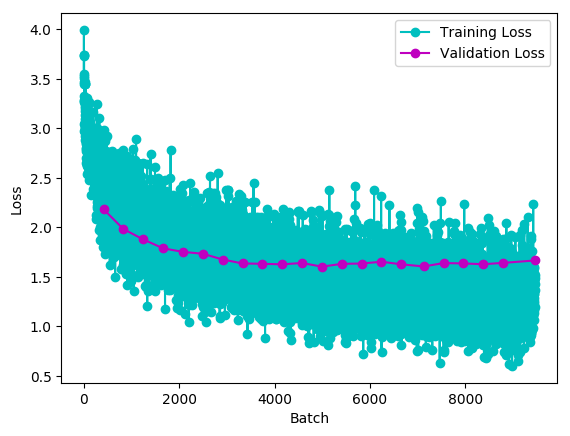

In [20]:
Image(filename='t2_dp/loss.png') 
# with 15 epochs, the training error is not lower enough. Now we want the model to be overfit a little more

In [21]:
%ls t2_dp/log/

batch_loss_batch          training_loss_batch       validation_loss_out_char
batch_loss_out_char       training_loss_out_char    validation_loss_time
batch_loss_time           training_loss_time        validation_loss_total
batch_loss_total          training_loss_total
summary.yml               validation_loss_batch


In [22]:
%pycat t2_dp/log/summary.yml
# {batches: 8790, epochs: 21, samples: 281028, sessions: 2, version: 2}


### What summary.yml is tell us?
- batches: 8790 == so far we have ran 8790 batches in training????
- epochs: 21 == we have ran 21 epochs in traning
- samples: 281028 == no idea what it means????
- sessions: 2   == no idea what it means???? 
- version: 2  == no idea what it means????



In [23]:
%%time
!kur -v evaluate char_rrn_demo_dp_fluid.yaml

[INFO 2017-03-05 22:08:42,957 kur.kurfile:699] Parsing source: char_rrn_demo_dp_fluid.yaml, included by top-level.
[INFO 2017-03-05 22:08:42,961 kur.kurfile:699] Parsing source: char_rnn_demo_dp_defaults.yaml, included by char_rrn_demo_dp_fluid.yaml.
[INFO 2017-03-05 22:08:42,971 kur.kurfile:82] Parsing Kurfile...
[INFO 2017-03-05 22:08:43,207 kur.backend.backend:80] Creating backend: keras
[INFO 2017-03-05 22:08:43,207 kur.backend.backend:83] Backend variants: none
[INFO 2017-03-05 22:08:43,208 kur.backend.keras_backend:122] No particular backend for Keras has been requested.
[INFO 2017-03-05 22:08:44,276 kur.backend.keras_backend:195] Keras is loaded. The backend is: theano
[INFO 2017-03-05 22:08:44,276 kur.model.model:260] Enumerating the model containers.
[INFO 2017-03-05 22:08:44,276 kur.model.model:265] Assembling the model dependency graph.
[INFO 2017-03-05 22:08:44,276 kur.model.model:280] Connecting the model graph.
[INFO 2017-03-05 22:08:46,508 kur.model.model:284] Model inpu

In [24]:
%%writefile view_outputs.py

"""
Copyright 2016 Deepgram

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

import numpy as np
import pickle
import sys
import view_data
from vocab import *


if len(sys.argv) < 2:
    pickle_fname = 't2_dp/output.pkl'
else:
    pickle_fname = sys.argv[1]

with open(pickle_fname, 'rb') as infile:
    prediction_data = pickle.load(infile)

data = view_data.get_data('evaluate')

batch_size = len(prediction_data['truth']['out_char'])

for j in range(10):
    predicted_char = int_to_char[np.argmax(prediction_data['result']['out_char'][j])]
    correct_char = int_to_char[np.argmax(data['out_char'][j])]
    print(
        '"%s" --> "%s"' % (
            ''.join([
                int_to_char[np.argmax(_)]
                for _ in data['in_seq'][j]
            ]),
            predicted_char
        )
    )
    if predicted_char == correct_char:
        print((' ' * (seq_len + 5)) + 'CORRECT')
    else:
        print((' ' * (seq_len + 5)) + 'INCORRECT (%s)' % correct_char)

accuracy = sum(
    [
        int(
            np.argmax(prediction_data['result']['out_char'][i]) == np.argmax(prediction_data['truth']['out_char'][i])
        )
        for i in range(batch_size)
    ]
) / float(len(prediction_data['truth']['out_char']))

print('accuracy = %s' % accuracy)

Overwriting view_outputs.py


In [25]:
!python view_outputs.py

"ng your time with me. mr. bing" --> "l"
                                   CORRECT
"g your time with me. mr. bingl" --> "e"
                                   CORRECT
" your time with me. mr. bingle" --> "y"
                                   CORRECT
"your time with me. mr. bingley" --> " "
                                   CORRECT
"our time with me. mr. bingley " --> "w"
                                   INCORRECT (f)
"ur time with me. mr. bingley f" --> "o"
                                   CORRECT
"r time with me. mr. bingley fo" --> "r"
                                   INCORRECT (l)
" time with me. mr. bingley fol" --> "l"
                                   CORRECT
"time with me. mr. bingley foll" --> "o"
                                   CORRECT
"ime with me. mr. bingley follo" --> "w"
                                   CORRECT
accuracy = 0.5270758122743683


In [26]:
!kur -v test char_rrn_demo_dp_fluid.yaml

[INFO 2017-03-05 22:09:03,629 kur.kurfile:699] Parsing source: char_rrn_demo_dp_fluid.yaml, included by top-level.
[INFO 2017-03-05 22:09:03,632 kur.kurfile:699] Parsing source: char_rnn_demo_dp_defaults.yaml, included by char_rrn_demo_dp_fluid.yaml.
[INFO 2017-03-05 22:09:03,642 kur.kurfile:82] Parsing Kurfile...
[INFO 2017-03-05 22:09:03,885 kur.backend.backend:80] Creating backend: keras
[INFO 2017-03-05 22:09:03,885 kur.backend.backend:83] Backend variants: none
[INFO 2017-03-05 22:09:03,885 kur.backend.keras_backend:122] No particular backend for Keras has been requested.
[INFO 2017-03-05 22:09:05,031 kur.backend.keras_backend:195] Keras is loaded. The backend is: theano
[INFO 2017-03-05 22:09:05,032 kur.model.model:260] Enumerating the model containers.
[INFO 2017-03-05 22:09:05,032 kur.model.model:265] Assembling the model dependency graph.
[INFO 2017-03-05 22:09:05,032 kur.model.model:280] Connecting the model graph.
[INFO 2017-03-05 22:09:06,459 kur.model.model:284] Model inpu

**Improvement**
- divergence is significantly reduced
- gradually converging

**Unsatistifed**
- original kurfile can achieve loss of 1.65 at epoch 3
- dropout version loss is 
- best loss with dropout version is 1.60 at epoch 12

**What more can be done?**
- should learning rate can adjusted?

## Try to write dlnd_character model (tensorflow) in kur
1. I am not sure I [understand the model in tensorflow correct](https://hyp.is/DzyoQAChEeeLJ0dOqLuF9A/nbviewer.jupyter.org/github/udacity/deep-learning/blob/master/intro-to-rnns/Anna%20KaRNNa.ipynb). I implemented below anyway, could you verify it for me?
- Assume I understand the tensorflow code properly, **does kur's LSTM and dropout operate similarly as Tensorflow's LSTM and dropout**? 
- In TF's doc, it says its `tf.contrib.rnn.BasicLSTMCell` is built based on [this paper](https://hyp.is/lHmEDACbEeeB_C_Ua4oMgA/arxiv.org/pdf/1409.2329.pdf)
- I see Kur does have gradient clipping, to write equivalence code to the [tensorflow code](https://hyp.is/ITh66ACqEee3Jd9Zbpvh4A/nbviewer.jupyter.org/github/udacity/deep-learning/blob/master/intro-to-rnns/Anna%20KaRNNa.ipynb), we shall use `clip: norm: grad_clip`, right?
- [tips on overfitting and underfitting](https://hyp.is/VavmwgCtEeeLXLcVygsOyw/nbviewer.jupyter.org/github/udacity/deep-learning/blob/master/intro-to-rnns/Anna%20KaRNNa.ipynb) from karpathy post
- [tips on balancing data size and model complexity](https://hyp.is/-gOR4gCuEeemKK-35u3Qnw/nbviewer.jupyter.org/github/udacity/deep-learning/blob/master/intro-to-rnns/Anna%20KaRNNa.ipynb)
- [how to find the best weights](https://hyp.is/0SE0QACvEeeDd8dKyAHb-w/nbviewer.jupyter.org/github/udacity/deep-learning/blob/master/intro-to-rnns/Anna%20KaRNNa.ipynb)

### dlnd_character model parameter values

- batch_size = 100    
- num_steps = 100     
- lstm_size = 512    
- num_layers = 2    
- learning_rate = 0.001    
- keep_prob = 0.5    

**Where can I find information about batch_size of original kur character example**?
- `batch_size` is not given in the original kurfile
- how do I know the default `batch_size`?

**To match dlnd parameters above with kur parameters**
```
- batch_size      = 100     vs     = 32 is default for kurfile, found it in `-vv` mode, we can set it freely 
- num_steps       = 100     vs     = 30 = seq_len = how many characters are used to predict the next character??
                                   = to set seq_len to 100, we have to go back to make_data stage, right????????
- lstm_size       = 512     vs     = 128 = rnn.size = how should I visualize `lstm_size` in my mind?
- num_layers      = 2       vs     = 3 = rnn.depth
- learning_rate   = 0.001   vs     = optimizer is missing in kurfile, adam optimizer with lr=0.001 used
- keep_prob       = 0.5     vs     = dropout 
```
- no fully connected (fc) layer specified in dlnd_example tensorflow code, does tensorflow automatically add fc_layer?
- is fc_layer or dense layer required in RNN model????

In [13]:
# in Karpathy's post, there are 5 types of RNN models
Image(width=800, height=500, url = "http://karpathy.github.io/assets/rnn/diags.jpeg")

In [20]:
##QUESTION: The following graph is the fifth type of RNN model(see above), not what we want for dlnd_project, right?
from IPython.display import Image
Image(width = 500, height = 300, url='http://nbviewer.jupyter.org/github/udacity/deep-learning/blob/master/intro-to-rnns/assets/charseq.jpeg')

In [38]:
####### QUESTION: we want type 4 model for this project, I draw the model in the graph below, please verify it for me
Image(retina = True, width = 1000, height=800, url="https://lh3.googleusercontent.com/-guWd9n2kabBmfhG3QSbd1PGBExjngc6uzWAKAuX-k-ML02o5Q_QyXyV-BP5F0KqVKbKiVBdtrt9_OsCJpaWseAPiF-rxhNqvmMaVmTYeTmQammdG3qoImzvjygsMJMHLN17IxbHt8u677szipeNBDQbOr_qviR6gLuMQMUwh6DydLuu8lYDCABE9M1QpBSbk6cHKeiFMI0FuqHfPNsjSPGgGuXYnVm7F6Mi6jEh2ewqNzmJjm6p106ClRlXxPLs2nAThCJKLQbnYanonEK-TSqay5XECSRhU_4YpAKNBpO_F32y-R1iUPfHuJv9JAFMJWPPfRDTbQ39mROyzpra3bp1fRL03OzS7zRrK0pWOXEKy4iDn-KyUp9ZAqCy__R2mCPZWaUMz3_K3G2jb0H0_IQHBxPH-hzrs_vcqIh1Xn7NsUt__6sM0ncjyiimAxhYqcx3eQs5kQBuzQA1HKGBjKPpglHEZvZFiSfnFVlm7qEw_eS9IhgXhjBY5PBY0B5NrRJgZtYpf4mH_O1JZd2gPlVf_klI6sGQdxiYOYjWQiqwy5LtPDsnWz8qN730TlS3eqxNpee0-GK9lPRbNAJFHQAIOncg4chHVoIKp-kyS0KAAwosWhlP=w1788-h1264-no")

In [39]:
%%writefile char_rnn_demo_dlnd_defaults.yaml

---

settings:


  vocab:                                         
    size: 30                          # This cannot be changed, it is fixed with dataset           
                
  

# QUESTION: what cause the following error, given the model build fine. see `build` in the next cell               
# we get the following error meassage: 
# Traceback (most recent call last):
#   File "/Users/Natsume/Downloads/kur_road/kur/kur/model/executor.py", line 224, in train
#     **kwargs
#   File "/Users/Natsume/Downloads/kur_road/kur/kur/model/executor.py", line 648, in wrapped_train
#     raise ValueError('Model loss is NaN.')
# ValueError: Model loss is NaN.
# 
# During handling of the above exception, another exception occurred:
# 
# Traceback (most recent call last):
#   File "/Users/Natsume/miniconda2/envs/dlnd-tf-lab/bin/kur", line 11, in <module>
#     load_entry_point('kur', 'console_scripts', 'kur')()
#   File "/Users/Natsume/Downloads/kur_road/kur/kur/__main__.py", line 382, in main
#     sys.exit(args.func(args) or 0)
#   File "/Users/Natsume/Downloads/kur_road/kur/kur/__main__.py", line 62, in train
#     func(step=args.step)
#   File "/Users/Natsume/Downloads/kur_road/kur/kur/kurfile.py", line 371, in func
#     return trainer.train(**defaults)
#   File "/Users/Natsume/Downloads/kur_road/kur/kur/model/executor.py", line 246, in train
#     info={'Reason' : reason}
#   File "/Users/Natsume/Downloads/kur_road/kur/kur/model/hooks/plot_hook.py", line 123, in notify
#     vbatch = numpy.arange(1, len(vloss)+1)
# TypeError: object of type 'NoneType' has no len()
# CPU times: user 511 ms, sys: 504 ms, total: 1.02 s
# Wall time: 31.6 s"""    

  rnn:
    size: 512                                    # num_neurons of a rnn/lstm layer
    depth: 2                                     # num_rnn_layers for this RNN model
        


model:
  - input: in_seq


  - recurrent:
      size: "{{ rnn.size }}"
      type: lstm
      sequence: True                             # yes, meaning return the whole sequence of 30 characters??
      bidirectional: no
  - batch_normalization
  - dropout: "{{drop_neurons}}"
        
  - recurrent:
      size: "{{ rnn.size }}"
      type: lstm
      sequence: False                     # no, meaning only return only 1 character of the whole 30 char sequence??
      bidirectional: no
  - batch_normalization
  - dropout: "{{drop_neurons}}"


  - dense: "{{ vocab.size }}"                   # now it is like 30 class-classification problem, 
                                                # that's why we need 30 neurons here, right? 

  - activation: softmax

  - output: out_char                               # make a name of output layer
           

loss:
  - target: out_char
    name: categorical_crossentropy

train:
  data:
    - jsonl: data/train.jsonl
  epochs: "{{ num_epochs|default(5) }}"     
  weights:
    initial: t3_dlnd/best.w.kur
    best: t3_dlnd/best.w.kur
    last: t3_dlnd/last.w.kur
  log: t3_dlnd/log
  hooks:                                   
    - plot: t3_dlnd/loss.png

validate:
  data:
    - jsonl: data/validate.jsonl
  weights: t3_dlnd/best.w.kur


test:
  data:
    - jsonl: data/test.jsonl
  weights: t3_dlnd/best.w.kur


evaluate:
  data:
    - jsonl: data/evaluate.jsonl
  weights: t3_dlnd/best.w.kur

  destination: t3_dlnd/output.pkl

Writing char_rnn_demo_dlnd_defaults.yaml


In [28]:
%%writefile char_rrn_demo_dlnd_fluid.yaml

---
settings: 
#   num_epochs: 15                    # leave it empty means inf number of epochs
                                 # so to use default value, just comment this line out
  drop_neurons: 0.5


include: char_rnn_demo_dlnd_defaults.yaml
...

Overwriting char_rrn_demo_dlnd_fluid.yaml


In [29]:
%%time
!kur -vv train char_rrn_demo_dlnd_fluid.yaml

[INFO 2017-03-05 22:26:41,982 kur.kurfile:699] Parsing source: char_rrn_demo_dlnd_fluid.yaml, included by top-level.
[INFO 2017-03-05 22:26:41,986 kur.kurfile:699] Parsing source: char_rnn_demo_dlnd_defaults.yaml, included by char_rrn_demo_dlnd_fluid.yaml.
[INFO 2017-03-05 22:26:41,999 kur.kurfile:82] Parsing Kurfile...
[DEBUG 2017-03-05 22:26:41,999 kur.kurfile:784] Parsing Kurfile section: settings
[DEBUG 2017-03-05 22:26:42,000 kur.kurfile:784] Parsing Kurfile section: train
[DEBUG 2017-03-05 22:26:42,004 kur.kurfile:784] Parsing Kurfile section: validate
[DEBUG 2017-03-05 22:26:42,005 kur.kurfile:784] Parsing Kurfile section: test
[DEBUG 2017-03-05 22:26:42,006 kur.kurfile:784] Parsing Kurfile section: evaluate
[DEBUG 2017-03-05 22:26:42,008 kur.containers.layers.placeholder:63] Using short-hand name for placeholder: in_seq
[DEBUG 2017-03-05 22:26:42,009 kur.containers.layers.placeholder:97] Placeholder "in_seq" has a deferred shape.
[DEBUG 2017-03-05 22:26:42,016 kur.containers.la

### The model above is built ok

In [30]:
!kur -vv build char_rrn_demo_dlnd_fluid.yaml

[INFO 2017-03-05 22:27:24,931 kur.kurfile:699] Parsing source: char_rrn_demo_dlnd_fluid.yaml, included by top-level.
[INFO 2017-03-05 22:27:24,935 kur.kurfile:699] Parsing source: char_rnn_demo_dlnd_defaults.yaml, included by char_rrn_demo_dlnd_fluid.yaml.
[INFO 2017-03-05 22:27:24,949 kur.kurfile:82] Parsing Kurfile...
[DEBUG 2017-03-05 22:27:24,950 kur.kurfile:784] Parsing Kurfile section: settings
[DEBUG 2017-03-05 22:27:24,950 kur.kurfile:784] Parsing Kurfile section: train
[DEBUG 2017-03-05 22:27:24,956 kur.kurfile:784] Parsing Kurfile section: validate
[DEBUG 2017-03-05 22:27:24,957 kur.kurfile:784] Parsing Kurfile section: test
[DEBUG 2017-03-05 22:27:24,958 kur.kurfile:784] Parsing Kurfile section: evaluate
[DEBUG 2017-03-05 22:27:24,962 kur.containers.layers.placeholder:63] Using short-hand name for placeholder: in_seq
[DEBUG 2017-03-05 22:27:24,963 kur.containers.layers.placeholder:97] Placeholder "in_seq" has a deferred shape.
[DEBUG 2017-03-05 22:27:24,972 kur.containers.la

# More tasks to do

**implement lots of tutorials in kur == deep learning understanding**
- try to implement as many deep learning tutorials in kur as possible
- I wonder would [keras](https://keras.io/layers/recurrent/) and [TL docs](http://tensorlayer.readthedocs.io/en/latest/modules/layers.html#fixed-length-recurrent-layer) or [TFLearn doc](http://tflearn.org/layers/recurrent/) provide more accessible knowledge for me to fill the gap presented by tensorflow?


**Add more Kur features**
- understand how data supplier of kur work: without it, I can't try other datasets
- **feature**: plot input to show the shape or structure of an input data point
    - so we know what exactly we feed to network
- **feature**: plotting weights and activation of each layer: [example](https://hyp.is/4O19zgFVEeeZcue639FnDQ/nbviewer.jupyter.org/github/EmbraceLife/Learn-from-Hvass-Labs-tensorflow/blob/master/2.CNN-MNIST.ipynb) of plot weights for mnist
- Here it can help me understand: what exact does **`output` layer** do, [kur doc](https://hyp.is/vrwiIAC4EeekgltPOmLV_Q/kur.deepgram.com/containers.html) does not make much sense for me?

# How to prepare data for RNN models

## Create Vocab: 30 unique characters in total
- set the length of context sequence as 30
- set vocab as a list of 30 unique characters: 26 letters with 4 symbols
- create two dictionaries: {char:index}, {index:char}
- get length of vocab

In [3]:
%pycat vocab.py

In [7]:
%%writefile data_supplier_char_rnn/vocab.py
"""
Copyright 2016 Deepgram

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

# length of the context sequence                        # what does context sequence mean? 
                                                        # a sequence of words used to predict the next word
seq_len = 30

                                                        # to create a list of 26 alphabet letter
lowercase_letters = [                             
    chr(97 + i) for i in range(26)
]

                                                        # define a list of 4 symbols: space, ", \, .
symbols = [' ', '"', '\'', '.']

                                                        # define a list of unique characters we allow in our data
vocab = lowercase_letters + symbols

                                                        # create a dictionary: {char:index}
                                                        # give each character an index
char_to_int = dict(
    (c, i) for i, c in enumerate(vocab)
)
                                                        # create a dictionary: {index:char}
                                                        # give each index an character
int_to_char = dict(enumerate(vocab))
                                                        # get the length of vocab
n_vocab = len(vocab)

Writing data_supplier_char_rnn/vocab.py


In [12]:
import data_supplier_char_rnn 
from data_supplier_char_rnn import vocab

In [13]:
vocab.n_vocab

30

In [14]:
vocab.char_to_int

{' ': 26,
 '"': 27,
 "'": 28,
 '.': 29,
 'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25}

In [15]:
vocab.int_to_char

{0: 'a',
 1: 'b',
 2: 'c',
 3: 'd',
 4: 'e',
 5: 'f',
 6: 'g',
 7: 'h',
 8: 'i',
 9: 'j',
 10: 'k',
 11: 'l',
 12: 'm',
 13: 'n',
 14: 'o',
 15: 'p',
 16: 'q',
 17: 'r',
 18: 's',
 19: 't',
 20: 'u',
 21: 'v',
 22: 'w',
 23: 'x',
 24: 'y',
 25: 'z',
 26: ' ',
 27: '"',
 28: "'",
 29: '.'}

## Make data for RNN model
- split all words into characters, and put them into a long list, the list into cleaned.txt
- create dataset for each section: train(80%), validate(5%), evaluate(5%), test(5%), we can **change pct here**
- each dataset is saved into jsonl file
- each jsonl file has 2 variables, `in_seq` as x, `out_char` as y, they are both list of list inside jsonl file
- total length of x or y of all sections tegother is about total_character - 30, (30 == len of sequence)
- each x input is a 3-d tensor (num_data_points, num_sequence_to_try, one-hot-encoding_input)
- each y output is a 2-d tensor (num_data_points, one-hot-encoding_input)

**Read make_data.py in detail**

In [2]:
%pycat make_data.py

In [61]:
%%writefile data_supplier_char_rnn/make_data.py
"""
Copyright 2016 Deepgram

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

import numpy as np
from vocab import *
import json
import os


if not os.path.exists('./data/'):             ### create a data folder if not already available ###
    os.mkdir('./data/')

                                              ### convert character from indices to one-hot-encoding ###
def one_hot(v, ndim):                         # v: indices of all the unique characters of a text
    v_one_hot = np.zeros(                     # ndim: num of all unique characters of the text
        (len(v), ndim,)
    )
    for i in range(len(v)):
        v_one_hot[i][v[i]] = 1.0              # for each unique character, make 1 at its index on column
    return v_one_hot

x = []
y = []

all_chars = []

                                              # for each book
for book in [
    'pride_and_prejudice.txt',
    'shakespeare.txt'
]:                                          
                                              # for every line of this book
    with open('books/%s' % book, 'r') as infile:
                                              # split every word into separate characters, a space separate each word
        chars = [
            c for c in ' '.join(infile.read().lower().split())
            if c in set(vocab)
        ]
        all_chars += [' ']
        all_chars += chars
                                              # put all words of book into a long list (see **example1** below)
            

                                              # get rid of the space in the beginning
all_chars = list(' '.join(''.join(all_chars).split()))
num_chars = len(all_chars)                    # count num of characters in the book including spaces


                                              # create an empty file named `cleaned.txt` to write data into
with open('cleaned.txt', 'w') as outfile:
                                              # write all the whole list of characters of the books into it
    outfile.write(''.join(all_chars))         # without a space in the beginning


x, y = [], []                                 # set x, y as empty list

                                            
                                              # define portions for each section: train, validate, evalute, test
data_portions = [
    ('train', 0.8),
    ('validate', 0.05),
    ('test', 0.05),
    ('evaluate', 0.05),
]

dev = True                                     # reduce amount of data for training x10 times
if dev:
                                               # shrink every section data by x10 times
        
    for i in range(len(data_portions)):
        data_portions[i] = (
            data_portions[i][0],
            data_portions[i][1] * 0.1
        )
        
        
                                               # sum up num of data points in each section (train, validate...) 
                                               # max_i = sum_above - seq_len
max_i = sum([
    int(round(len(all_chars) * fraction))
    for name, fraction in data_portions
]) - seq_len                                   # seq_len is defined inside vocab.py as 30


                                               # for every element of max_i 
for i in range(max_i):
                                               # create a short list of length 30, assign to in_char_seq
                                               # every in_char_seq only has 1 character different to its neighbour
    in_char_seq = all_chars[i: i + seq_len]

                                               # one hot representation
                                               # create a matrix of 0s with dim(30, 30), assigned to sample_x
    sample_x = np.zeros((len(in_char_seq), n_vocab,))
    
                                                
    for j, c in enumerate(in_char_seq):        # j as index from 0 to 29, c as character 
        sample_x[j][char_to_int[c]] = 1        # find unique index of the character, and put 1 in the index of column
                                               # by now, a list of 30 characters turned into a matrix of 0s and 1s 
                                               # in other words, 30 character in one-hot-encoding format 
                                                
    x.append(sample_x)                         # tranform all characters into one-hot-encoding format and save them
                                               # all in x (x was an empty list)
                                               # what does x look like? - a list of arrays see **example2** #######
        
        
                                               # create a 1-d array of 0s of length 30 for sample_y 
    sample_y = np.zeros(n_vocab)
    
                                               # get all characters from the 30th onward
                                               # get the unique index of the character
                                               # make the location of the index from 0 to 1
    sample_y[char_to_int[all_chars[i + seq_len]]] = 1
    y.append(sample_y)                         # now, we transformed the y from character to one-hot-encoding

    
                                               # convert x, y from lists to arrays of arrays
x, y = np.array(x).astype('int32'), np.array(y).astype('int32') 
                                               # x as 3-d (max_i, 30, 30), y as 2-d (max_i, 30)  
                                                                                        # see **example2** #######


                                                # set starting index
start_i = 0     
                                                # for each section: train, validate, evaluate, test
for name, fraction in data_portions:
                                                # get ending index of each section
    end_i = start_i + int(round(len(x) * fraction))    # len(x) == max_i
    print(start_i, end_i)
    x0 = x[start_i: end_i]
    y0 = y[start_i: end_i]
                                                # print dim of each section's x and y
    print('dims:')
    print(x0.shape)
    print(y0.shape)
                                                # set current section's ending index as starting index of next section
    start_i = end_i
                                                # open an empty jsonl file and write to it
    with open('data/%s.jsonl' % name, 'w') as outfile:
        for sample_x, sample_y in zip(x0, y0):  # zip sample_x and sample_y together
            outfile.write(json.dumps({
                'in_seq': sample_x.tolist(),    # write into file as list of list rather than numpy arrays
                'out_char': sample_y.tolist()
            }))
            outfile.write('\n')

    del x0, y0

Writing data_supplier_char_rnn/make_data.py


### example1

In [25]:
all_chars = []

                                              # for each book
for book in [
    'pride_and_prejudice.txt',
    'shakespeare.txt'
]:                                          
                                              # for every line of this book
    with open('books/%s' % book, 'r') as infile:
                                              # split each line into characters, and join them by a space
        chars = [
            c for c in ' '.join(infile.read().lower().split())
            if c in set(vocab.vocab)
        ]
        all_chars += [' ']
        all_chars += chars

In [27]:
all_chars[0:30]

[' ',
 't',
 'h',
 'e',
 ' ',
 'p',
 'r',
 'o',
 'j',
 'e',
 'c',
 't',
 ' ',
 'g',
 'u',
 't',
 'e',
 'n',
 'b',
 'e',
 'r',
 'g',
 ' ',
 'e',
 'b',
 'o',
 'o',
 'k',
 ' ',
 'o']

In [28]:
all_chars = list(' '.join(''.join(all_chars).split()))
num_chars = len(all_chars)

In [31]:
num_chars

1750339

### example2

In [43]:
import numpy as np
a = np.zeros((30,30,))
b = np.ones((30,30))

In [44]:
c = []
c.append(a)
c.append(b)
c

[array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0

In [45]:
np.array(c).shape # 2 * 30 = number of data points 

(2, 30, 30)

In [47]:
d = np.array(c)
len(d)

2

In [60]:
print(len(d.tolist()))
print(len(d.tolist()[0]))
print(len(d.tolist()[0][0]))
type(d.tolist()[0][0][0])

2
30
30


float

## Combine vocab.py and make_data.py
- both files work together to produce datasets;
- Users like to change length of sequence freely, but they can't change length of sequence in kurfile at all;
- combine both files into one single function and make length of sequence an argument

In [100]:
%ls

__pycache__/                      data/
books/                            data_supplier_char_rnn/
char_rnn_demo.yaml                make_data.py
char_rnn_demo_defaults.yaml       steps.sh
char_rnn_demo_dlnd_defaults.yaml  t1/
char_rnn_demo_dp_defaults.yaml    t2_dp/
char_rnn_kur.ipynb                t3_dlnd/
char_rrn_demo_dlnd_fluid.yaml     view_data.py
char_rrn_demo_dp_fluid.yaml       view_logs.py
char_rrn_demo_fluid.yaml          view_outputs.py
cleaned.txt                       vocab.py


In [101]:
%pycat char_rnn_demo.yaml
# there is only vocab variable inside kurfile, but it can't be changed

In [119]:
%%writefile make_data_func.py
# vocab.py

# length of the context sequence                        # what does context sequence mean? 
                                                        # a sequence of words used to predict the next word
# seq_len = 30

                                                        # to create a list of 26 alphabet letter
lowercase_letters = [                             
    chr(97 + i) for i in range(26)
]

                                                        # define a list of 4 symbols: space, ", \, .
symbols = [' ', '"', '\'', '.']             ############# QUESTION: all other numbers and symbols are ignored, ### 
                                                        # in what situations this is common practice on vocab? ###
                                                        # in what situations should we keep all num and symbols ##

                                                        # define a list of unique characters we allow in our data
vocab = lowercase_letters + symbols

                                                        # create a dictionary: {char:index}
                                                        # give each character an index
char_to_int = dict(
    (c, i) for i, c in enumerate(vocab)
)
                                                        # create a dictionary: {index:char}
                                                        # give each index an character
int_to_char = dict(enumerate(vocab))
                                                        # get the length of vocab
n_vocab = len(vocab)

###############################################################################################

# make_data.py


import numpy as np
from vocab import *
import json
import os

                                                 # given 30 character in sequence to predict the next character
                                                 # dev = True, is to only use 10% of data
def make_data(seq_len=30, dev=True):

    if not os.path.exists('./data/'):             ### create a data folder if not already available ###
        os.mkdir('./data/')

                                                  ### convert character from indices to one-hot-encoding ###
    def one_hot(v, ndim):                         # v: indices of all the unique characters of a text
        v_one_hot = np.zeros(                     # ndim: num of all unique characters of the text
            (len(v), ndim,)
        )
        for i in range(len(v)):
            v_one_hot[i][v[i]] = 1.0              # for each unique character, make 1 at its index on column
        return v_one_hot

    x = []
    y = []

    all_chars = []

                                                  # for each book
    for book in [
        'pride_and_prejudice.txt',
        'shakespeare.txt'
    ]:                                          
                                                  # for every line of this book
        with open('books/%s' % book, 'r') as infile:
                                                  # split every word into separate characters, a space separate each word
            chars = [
                c for c in ' '.join(infile.read().lower().split())
                if c in set(vocab)
            ]
            all_chars += [' ']
            all_chars += chars
                                                  # put all words of book into a long list (see **example1** below)


                                                  # get rid of the space in the beginning
    all_chars = list(' '.join(''.join(all_chars).split()))
    num_chars = len(all_chars)                    # count num of characters in the book including spaces


                                                  # create an empty file named `cleaned.txt` to write data into
    with open('cleaned.txt', 'w') as outfile:
                                                  # write all the whole list of characters of the books into it
        outfile.write(''.join(all_chars))         # without a space in the beginning


    x, y = [], []                                 # set x, y as empty list


                                                  # define portions for each section: train, validate, evalute, test
    data_portions = [
        ('train', 0.8),
        ('validate', 0.05),
        ('test', 0.05),
        ('evaluate', 0.05),
    ]

#     dev = True                                     # reduce amount of data for training x10 times
    if dev:
                                                   # shrink every section data by x10 times

        for i in range(len(data_portions)):
            data_portions[i] = (
                data_portions[i][0],
                data_portions[i][1] * 0.1
            )


                                                   # sum up num of data points in each section (train, validate...) 
                                                   # max_i = sum_above - seq_len
    max_i = sum([
        int(round(len(all_chars) * fraction))
        for name, fraction in data_portions
    ]) - seq_len                                   # seq_len is defined inside vocab.py as 30


                                                   # for every element of max_i 
    for i in range(max_i):
                                                   # create a short list of length 30, assign to in_char_seq
                                                   # every in_char_seq only has 1 character different to its neighbour
        in_char_seq = all_chars[i: i + seq_len]

                                                   # one hot representation
                                                   # create a matrix of 0s with dim(30, 30), assigned to sample_x
        sample_x = np.zeros((len(in_char_seq), n_vocab,))


        for j, c in enumerate(in_char_seq):        # j as index from 0 to 29, c as character 
            sample_x[j][char_to_int[c]] = 1        # find unique index of the character, and put 1 in the index of column
                                                   # by now, a list of 30 characters turned into a matrix of 0s and 1s 
                                                   # in other words, 30 character in one-hot-encoding format 

        x.append(sample_x)                         # tranform all characters into one-hot-encoding format and save them
                                                   # all in x (x was an empty list)
                                                   # what does x look like? - a list of arrays see **example2** #######


                                                   # create a 1-d array of 0s of length 30 for sample_y 
        sample_y = np.zeros(n_vocab)

                                                   # get all characters from the 30th onward
                                                   # get the unique index of the character
                                                   # make the location of the index from 0 to 1
        sample_y[char_to_int[all_chars[i + seq_len]]] = 1
        y.append(sample_y)                         # now, we transformed the y from character to one-hot-encoding


                                                   # convert x, y from lists to arrays of arrays
    x, y = np.array(x).astype('int32'), np.array(y).astype('int32') 
                                                   # x as 3-d (max_i, 30, 30), y as 2-d (max_i, 30)  
                                                                                            # see **example2** #######


                                                    # set starting index
    start_i = 0     
                                                    # for each section: train, validate, evaluate, test
    for name, fraction in data_portions:
                                                    # get ending index of each section
        end_i = start_i + int(round(len(x) * fraction))    # len(x) == max_i
        print(start_i, end_i)
        x0 = x[start_i: end_i]
        y0 = y[start_i: end_i]
                                                    # print dim of each section's x and y
        print('dims:')
        print(x0.shape)
        print(y0.shape)
                                                    # set current section's ending index as starting index of next section
        start_i = end_i
                                                    # open an empty jsonl file and write to it
        with open('data/%s.jsonl' % name, 'w') as outfile:
            for sample_x, sample_y in zip(x0, y0):  # zip sample_x and sample_y together
                outfile.write(json.dumps({
                    'in_seq': sample_x.tolist(),    # write into file as list of list rather than numpy arrays
                    'out_char': sample_y.tolist()   # QUESTION: it means kur accept lists from jsonl file by default
                }))
                outfile.write('\n')

        del x0, y0

Overwriting make_data_func.py


## make data with seq_len = 50

In [31]:
%ls

__pycache__/                      data/
books/                            data_supplier_char_rnn/
char_rnn_demo.yaml                make_data.py
char_rnn_demo_defaults.yaml       steps.sh
char_rnn_demo_dlnd_defaults.yaml  t1/
char_rnn_demo_dp_defaults.yaml    t2_dp/
char_rnn_kur.ipynb                t3_dlnd/
char_rrn_demo_dlnd_fluid.yaml     view_data.py
char_rrn_demo_dp_fluid.yaml       view_logs.py
char_rrn_demo_fluid.yaml          view_outputs.py
cleaned.txt                       vocab.py


In [32]:
%cd data_supplier_char_rnn/

/Users/Natsume/Downloads/kur_road/character_rnn/data_supplier_char_rnn


In [33]:
from make_data_func import *
# make_data()

In [34]:
# %pycat make_data_func.py
make_data(seq_len = 50)

0 13299
dims:
(13299, 50, 30)
(13299, 30)
13299 14130
dims:
(831, 50, 30)
(831, 30)
14130 14961
dims:
(831, 50, 30)
(831, 30)
14961 15792
dims:
(831, 50, 30)
(831, 30)


## View data for model

In [62]:
%pycat view_data.py

In [6]:
%%writefile view_data.py
"""
Copyright 2016 Deepgram

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

import numpy as np
import json
from vocab import *


# this script shows sections of size `window` from the ends
# of each data file. its output looks like this:
# peek at train:
# ------
# "the project gutenberg ebook of" --> " "
# "he project gutenberg ebook of " --> "p"
# "e project gutenberg ebook of p" --> "r"
# ------
# "o particular resentment by his" --> " "
# " particular resentment by his " --> "h"
# "particular resentment by his h" --> "a"


# peek at validate:
# ------
# "articular resentment by his ha" --> "v"
# "rticular resentment by his hav" --> "i"
# "ticular resentment by his havi" --> "n"
# ------
# "ingley for a kingdom upon my h" --> "o"
# "ngley for a kingdom upon my ho" --> "n"
# "gley for a kingdom upon my hon" --> "o"


# peek at test:
# ------
# "ley for a kingdom upon my hono" --> "u"
# "ey for a kingdom upon my honou" --> "r"
# "y for a kingdom upon my honour" --> " "
# ------
# "sting your time with me. mr. b" --> "i"
# "ting your time with me. mr. bi" --> "n"
# "ing your time with me. mr. bin" --> "g"


# peek at evaluate:
# ------
# "ng your time with me. mr. bing" --> "l"
# "g your time with me. mr. bingl" --> "e"
# " your time with me. mr. bingle" --> "y"
# ------
# "they had yet learnt to care fo" --> "r"
# "hey had yet learnt to care for" --> " "
# "ey had yet learnt to care for " --> "a"

                                                        # set a window to print data
window = 3

                                                        # get data out of jsonl file
def get_data(name):
    with open('data/%s.jsonl' % name, 'r') as infile:   # read infile out of jsonl file
                                                        # create an empty dictionary
        data = {}                   

        data = {                                        # use the first line to create key and first element of value
            key: [value]
            for key, value in json.loads(next(infile)).items()
        }
                                                        # loop through the rest lines of infile to fill data dict
        for line in infile:
            line = line.strip()
            if not line:
                continue
            for key, value in json.loads(line).items():
                data[key].append(value)
                                                        # turn data's values into np.arrays
        for key in data:
            data[key] = np.array(data[key])

    return data

                                                        # print out a window of data with a given name
def view_data(name):
    data = get_data(name)                               # get a sepcific section data

    print('\n\npeek at %s:' % name)
                                                        # first j_range == first 3 data points 
                                                        # second j_range == last 3 data points 
    for j_range in (range(window), range(len(data['in_seq']) - window, len(data['in_seq'])),):
        print('------')
        for j in j_range:
            print(
                '"%s" --> "%s"' % (                      # print one x data point which is a (30, 30) array
                    ''.join([                            # join the elements of list below into a string
                                                         # turn list of argmax into characters
                        int_to_char[np.argmax(_)]        # take the 2-d array below, and flatten it to list of argmax
                        for _ in data['in_seq'][j]       # take a 2-d (30,30) array at a time
                    ]),
                                                         # print one y data point which is (1, 30) array
                    int_to_char[np.argmax(data['out_char'][j])]
                )
            )

if __name__ == '__main__':
    for name in ('train', 'validate', 'test', 'evaluate',):
        view_data(name)

Writing view_data.py


In [99]:
for i in (range(10), range(10,20)): 
    print(i)

range(0, 10)
range(10, 20)


In [98]:
for i in range(10, 20):
    print(i)

10
11
12
13
14
15
16
17
18
19


In [ ]:
np.argmax()

### example1: use just the first set of in_sep and out_char for data

In [90]:
name = 'test'
with open('data/%s.jsonl' % name, 'r') as infile:   # read infile out of jsonl file
        data = {}

        data = {                                        # turn infile to a dict {key: [value]}
            key: [value]
            for key, value in json.loads(next(infile)).items()
        }
        for key in data:
            data[key] = np.array(data[key])

In [91]:
print(data.keys())
print(data['in_seq'])
print(data['out_char'])
data['in_seq'].shape

dict_keys(['out_char', 'in_seq'])
[[[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
  [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
  [0 0

(1, 30, 30)

### use the rest of infile lines to fill data

In [88]:
name = 'test'
with open('data/%s.jsonl' % name, 'r') as infile:   # read infile out of jsonl file
    data = {}

    data = {                                        # turn infile to a dict {key: [value]}
        key: [value]
        for key, value in json.loads(next(infile)).items()
    }
    
    count = 0
    for line in infile:
        line = line.strip()
        if not line:
            continue
        for key, value in json.loads(line).items():
            if count < 3:
                print(key, value)
            count += 1    
            data[key].append(value)

#     for key in data:
#         data[key] = np.array(data[key])

out_char [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
in_seq [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [82]:
len(data['in_seq'])

831

In [7]:
!python view_data.py



peek at train:
------
"the project gutenberg ebook of pride and prejudice" --> " "
"he project gutenberg ebook of pride and prejudice " --> "b"
"e project gutenberg ebook of pride and prejudice b" --> "y"
------
"to particular resentment by his having slighted on" --> "e"
"o particular resentment by his having slighted one" --> " "
" particular resentment by his having slighted one " --> "o"


peek at validate:
------
"particular resentment by his having slighted one o" --> "f"
"articular resentment by his having slighted one of" --> " "
"rticular resentment by his having slighted one of " --> "h"
------
"bingley for a kingdom upon my honour i never met w" --> "i"
"ingley for a kingdom upon my honour i never met wi" --> "t"
"ngley for a kingdom upon my honour i never met wit" --> "h"


peek at test:
------
"gley for a kingdom upon my honour i never met with" --> " "
"ley for a kingdom upon my honour i never met with " --> "s"
"ey for a kingdom upon my honour i never met with s" --> "

## Train in debug mode

In [36]:
%pycat char_rrn_demo_dp_fluid.yaml

In [35]:
!kur -vv train char_rrn_demo_dp_fluid.yaml

[INFO 2017-03-05 22:30:43,216 kur.kurfile:699] Parsing source: char_rrn_demo_dp_fluid.yaml, included by top-level.
[INFO 2017-03-05 22:30:43,220 kur.kurfile:699] Parsing source: char_rnn_demo_dp_defaults.yaml, included by char_rrn_demo_dp_fluid.yaml.
[INFO 2017-03-05 22:30:43,231 kur.kurfile:82] Parsing Kurfile...
[DEBUG 2017-03-05 22:30:43,231 kur.kurfile:784] Parsing Kurfile section: settings
[DEBUG 2017-03-05 22:30:43,232 kur.kurfile:784] Parsing Kurfile section: train
[DEBUG 2017-03-05 22:30:43,236 kur.kurfile:784] Parsing Kurfile section: validate
[DEBUG 2017-03-05 22:30:43,237 kur.kurfile:784] Parsing Kurfile section: test
[DEBUG 2017-03-05 22:30:43,238 kur.kurfile:784] Parsing Kurfile section: evaluate
[DEBUG 2017-03-05 22:30:43,240 kur.containers.layers.placeholder:63] Using short-hand name for placeholder: in_seq
[DEBUG 2017-03-05 22:30:43,241 kur.containers.layers.placeholder:97] Placeholder "in_seq" has a deferred shape.
[DEBUG 2017-03-05 22:30:43,251 kur.containers.layers.o